In [2]:
import os
import sys
import tarfile
import numpy as np
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_settings_v3 import *
from dismantling import get_index_list
from planar import create_proximity_graph, distance
from auxiliary import get_base_network_name

fig_dir = '../draft/figs'
param = 'param'

attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
}

In [138]:
L = 6
N = L*L
g = ig.Graph().Lattice(dim=[L, L], circular=False)
g.summary()

position = np.array([[i//L, i%L] for i in range(N)])

In [139]:
attacks = ['Btw', 'BtwU']
index_lists = {}
for attack in attacks:
    index_list = get_index_list(g, attack)
    index_lists[attack] = index_list

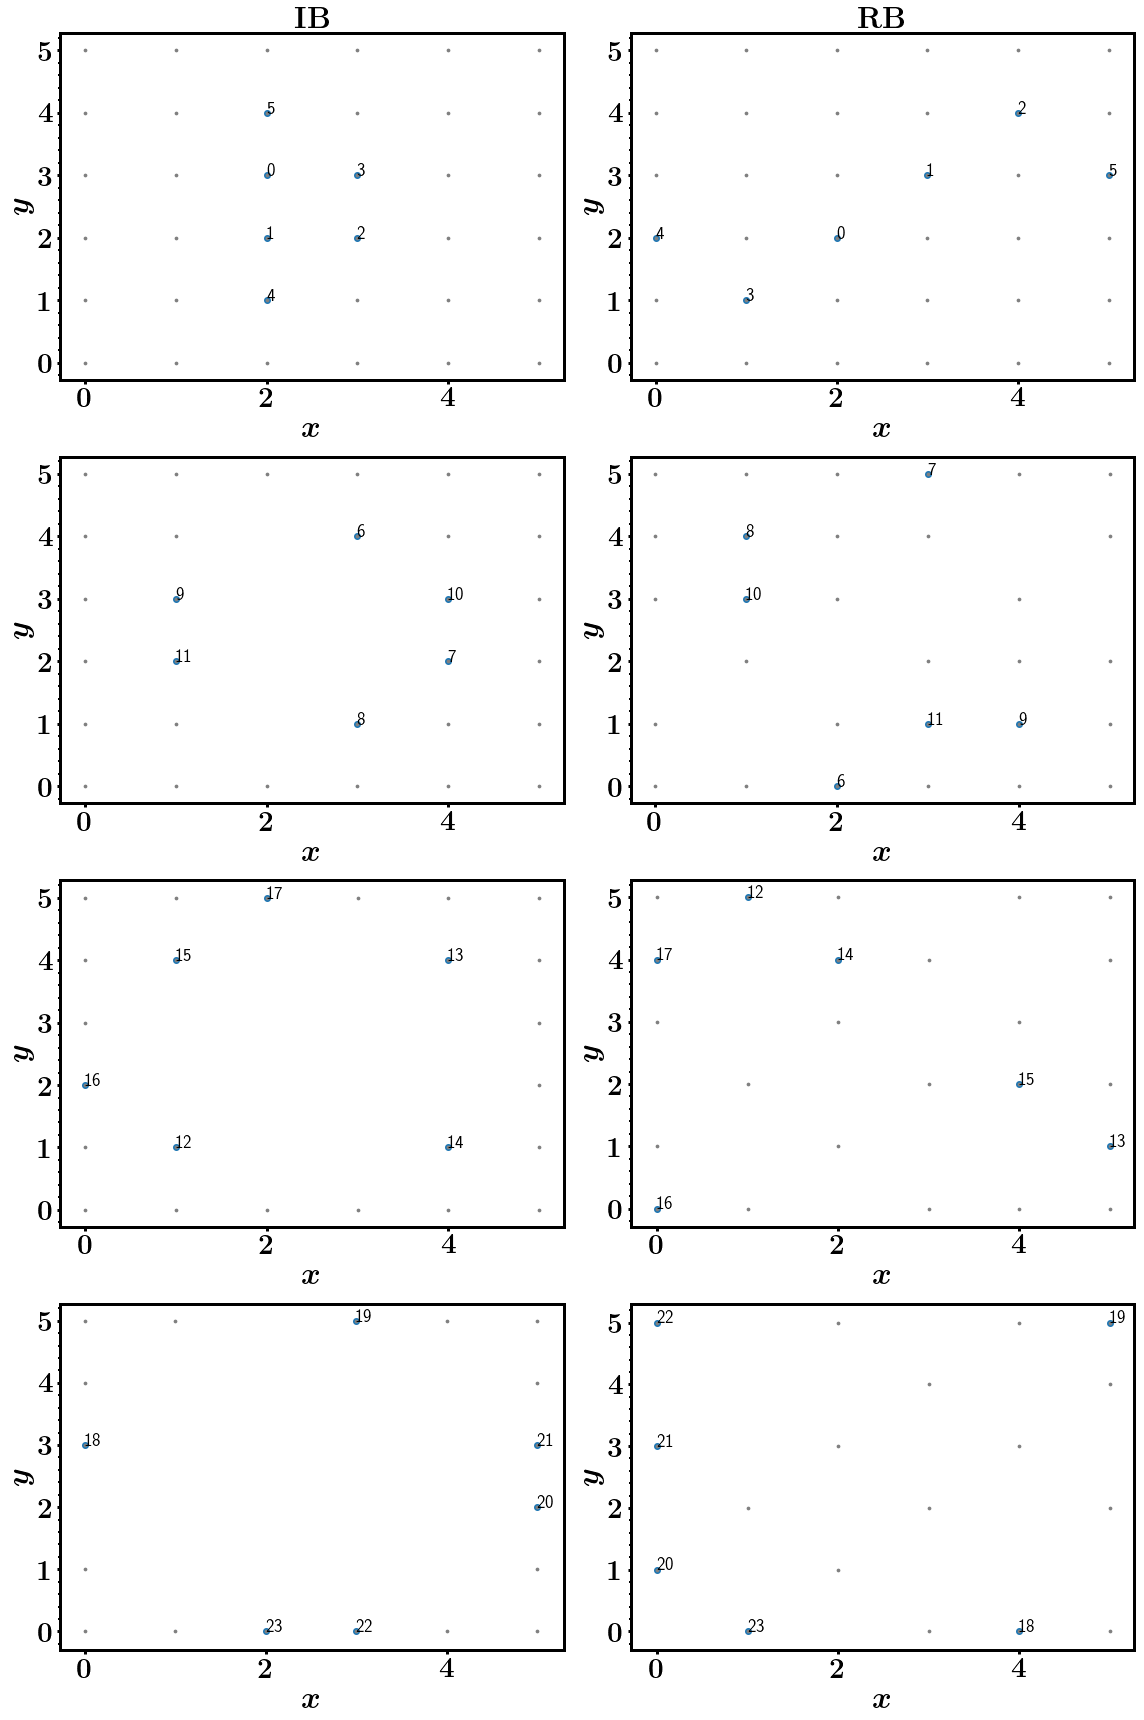

In [140]:
thresholds = [0, L, 2*L, 3*L]
ncols = 2
nrows = len(thresholds)
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for k in range(nrows):

    for i, attack in enumerate(attacks):
        ax = axes[k, i]
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        
        ax.set_xticks = range(L)
        ax.set_yticks = range(L)
        
        if k == 0:
            ax.set_title(attack_dict[attack], fontsize=30)
        for j, idx in enumerate(index_lists[attack][k*L:(k+1)*L]):
            ax.scatter(*position[idx], s=30, color=colors[0])
            ax.text(*position[idx], '{}'.format(j+k*L), fontsize=18)
        for idx in index_lists[attack][k*L:]:
            ax.scatter(*position[idx], s=5, color='grey')
            
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Btw_vs_BtwU_Lattice_L{}'.format(L))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [63]:
L = 50
N = L*L
seed = 0
g = create_proximity_graph('DT', N=N, random_seed=seed)
position = g.vs['position']
g.summary()

'IGRAPH U--- 2500 7471 -- \n+ attr: position (v)'

In [64]:
attacks = ['Btw', 'BtwU']
index_lists = {}
for attack in attacks:
    index_list = get_index_list(g, attack)
    index_lists[attack] = index_list

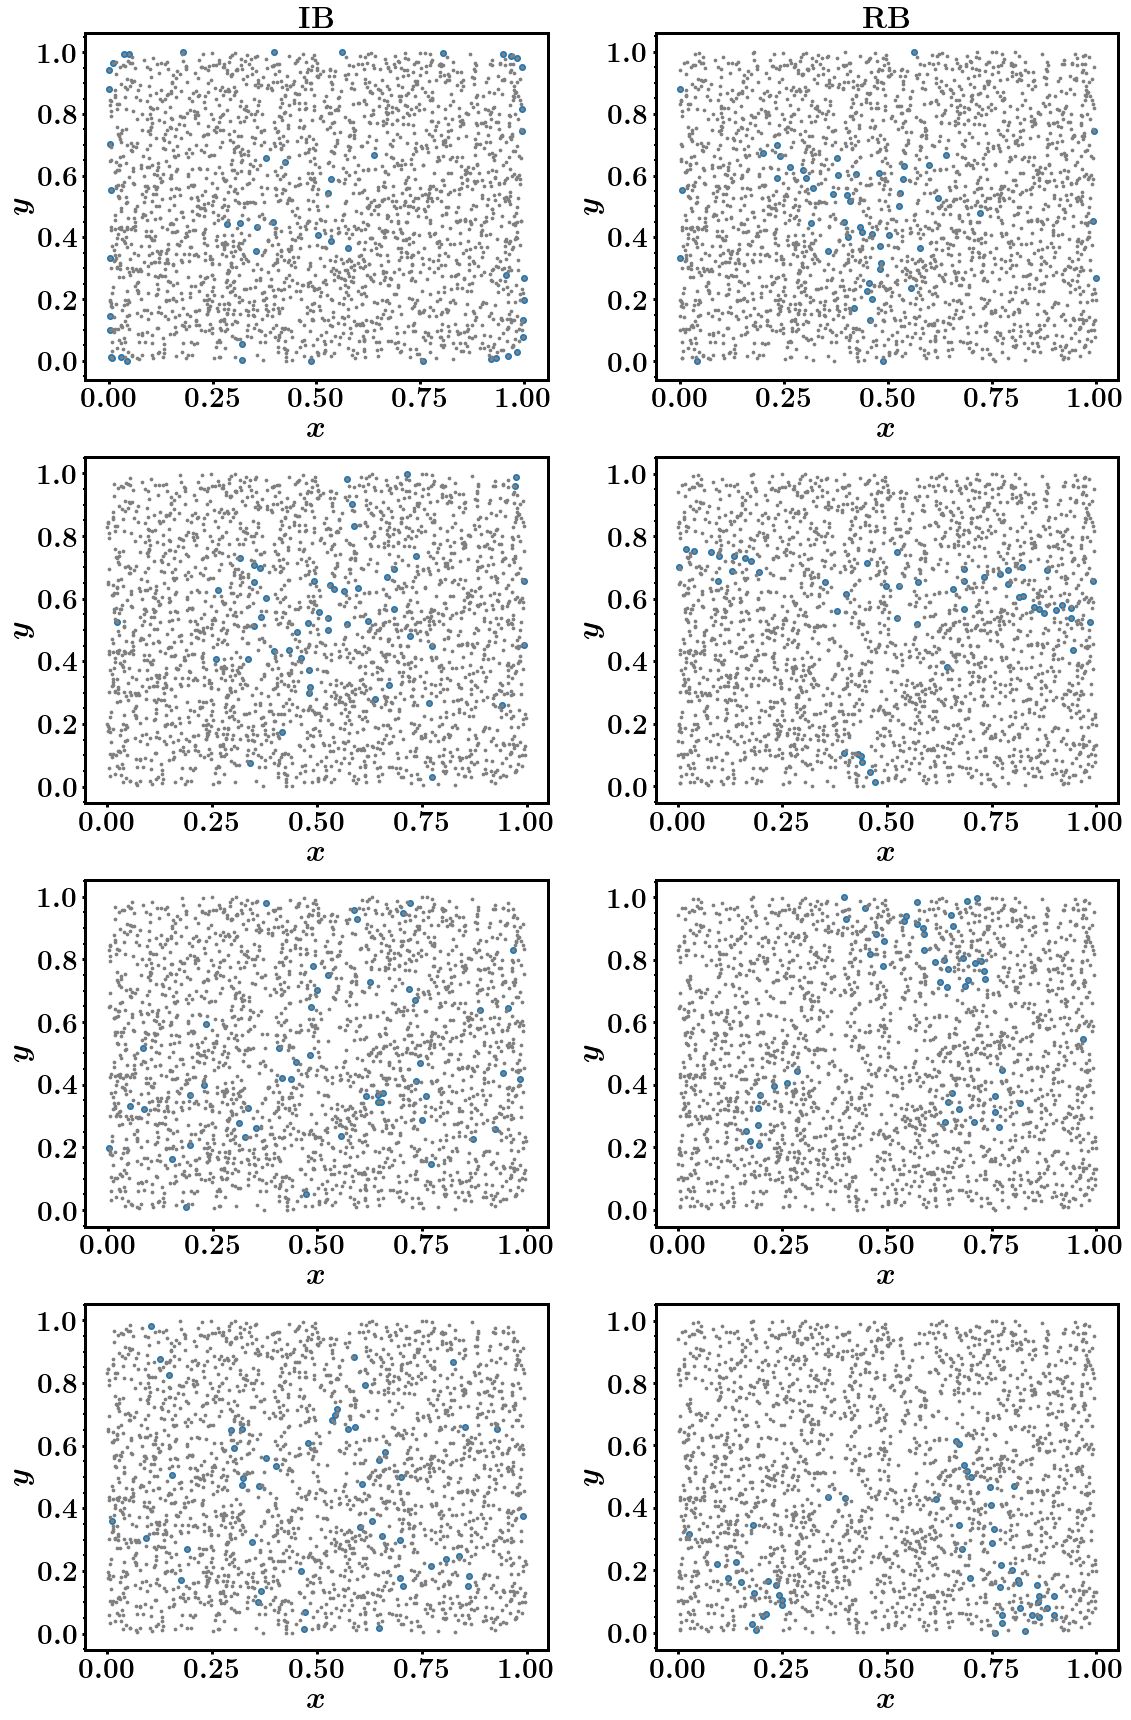

In [65]:
thresholds = [0, L, 2*L, 3*L]
ncols = 2
nrows = len(thresholds)
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for k in range(nrows):

    for i, attack in enumerate(attacks):
        ax = axes[k, i]
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        
        ax.set_xticks = range(L)
        ax.set_yticks = range(L)
        
        if k == 0:
            ax.set_title(attack_dict[attack], fontsize=30)
        for j, idx in enumerate(index_lists[attack][k*L:(k+1)*L]):
            ax.scatter(*position[idx], s=30, color=colors[0])
            #ax.text(*position[idx], '{}'.format(j+k*L), fontsize=18)
        for idx in index_lists[attack][k*L:]:
            ax.scatter(*position[idx], s=5, color='grey')
            
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Btw_vs_BtwU_DT_L{}'.format(L))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [5]:
L = 64
N = L*L
attack = 'BtwU'
networks = ['Lattice', 'DT']
seeds = {
    'Lattice': 0,
    'DT': 0
}

size = {
    'Lattice': L,
    'DT': N
}

index_lists = {}
positions = {}
thresholds = {}
gcc_members_values = {}
sec_members_values = {}
for net_type in networks:
    seed = seeds[net_type]
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size[net_type], param)
    net_name = base_net_name_size + '_{:05d}'.format(seed)
    base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)
    net_dir = os.path.join(base_net_dir, net_name)
    
    attack_dir_name = os.path.join(base_net_dir, net_name, attack)
    oi_file_name = os.path.join(attack_dir_name, 'oi_list.txt')
    index_list = np.loadtxt(oi_file_name, dtype='int')
    index_lists[net_type] = index_list
    
    if net_type == 'Lattice':
        position = np.array([[i//L, i%L] for i in range(N)])
    else:
        pos_file_name = os.path.join(dir_name, base_net_name,
            base_net_name_size, base_net_name_size + '_{:05}'.format(seed), 'position.txt'
        )
        position = np.loadtxt(pos_file_name) * L

    positions[net_type] = position


    ## Extract network file
    tar_input_name = net_name + '.tar.gz'
    full_tar_input_name = os.path.join(net_dir, tar_input_name)
    tar = tarfile.open(full_tar_input_name, 'r:gz')
    tar.extractall(net_dir)
    tar.close()

    input_name = net_name + '.txt'
    full_input_name = os.path.join(net_dir, input_name)
    
    ## Read network file
    g = ig.Graph().Read_Edgelist(full_input_name, directed=False)
    
    ## Remove network file
    os.remove(full_input_name)

    tar_input_name = 'comp_data.tar.gz'
    full_tar_input_name = os.path.join(attack_dir_name, tar_input_name)
    tar = tarfile.open(full_tar_input_name, 'r:gz')
    tar.extractall(attack_dir_name)
    tar.close()

    full_file_name  = os.path.join(attack_dir_name, 'comp_data.txt')
    aux = np.loadtxt(full_file_name)
    os.remove(full_file_name)

    Sgcc_values = aux[:,0][::-1] / N
    delta_values = np.abs(np.diff(Sgcc_values))
    max_pos = np.argmax(delta_values)
    delta_max = delta_values[max_pos]
    th = [0]
    th.append(max_pos+1)
    thresholds[net_type] = th
    
    g.vs['oi'] = range(g.vcount())
    g.delete_vertices(index_list[:max_pos+1])
    
    gcc = g.components(mode='WEAK').giant()
    membership = np.array(g.components(mode='WEAK').membership)

    number, count = np.unique(membership, return_counts=True)
    number_max, number_sec = number[np.argsort(count)[::-1][:2]]

    gcc_members = np.where(membership==number_max)[0]
    sec_members = np.where(membership==number_sec)[0]
    
    gcc_members_values[net_type] = [g.vs[index]['oi'] for index in gcc_members]
    sec_members_values[net_type] = [g.vs[index]['oi'] for index in sec_members]
    
    print(th, delta_max, delta_max*L, delta_max*L*L)

[0, 66] 0.49169921875 31.46875 2014.0


OSError: ../networks/DT/DT_param/DT_param_N4096/DT_param_N4096_00000/position.txt not found.

Lattice
Eigenvectors 
[[-0.73606302 -0.67691302]
 [ 0.67691302 -0.73606302]]

Eigenvalues 
[ 0.19410588 41.67256079]
lambda1 / lambda2 = 0.004657882108172196
DT
Eigenvectors 
[[0.98431665 0.17641068]
 [0.98431665 0.17641068]]

Eigenvalues 
[ 2.2069258  22.61368014]
lambda1 / lambda2 = 0.09759250968865395


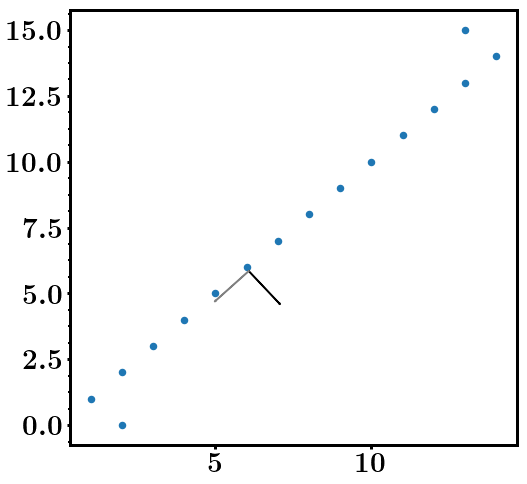

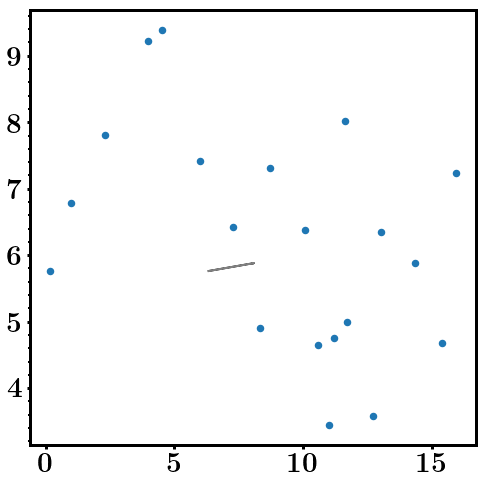

In [57]:
__pos = {}
for network in networks:
    print(network)
    th = thresholds[network]
    index_list = index_lists[network]
    position = positions[network]
        
    #print(len(index_list[th[0]:th[1]]))
    n = th[1] - th[0]
    X = np.zeros((n,2))
    for i, index in enumerate(index_list[th[0]:th[1]]):
        X[i] = position[index]
    
    from sklearn.preprocessing import StandardScaler
    #X = StandardScaler().fit_transform(X)    
    
    __pos[network] = index_list[th[0]:th[1]]
    if network == 'Lattice':
        _aux = X
    cor_mat = np.cov(X.T)

    eig_vals, eig_vecs = np.linalg.eig(cor_mat)

    if eig_vals[1] < eig_vals[0]:
        aux = eig_vals[1]
        eig_vals[1] = eig_vals[0]
        eig_vals[0] = aux
        
        aux = eig_vecs[1]
        eig_vecs[1] = eig_vecs[0]
        eig_vecs[0] = aux
    
    #eig_vecs[0] = eig_vecs[0] / np.sum(eig_vecs[0]**2)
    #eig_vecs[1] = eig_vecs[1] / np.sum(eig_vecs[1]**2)
    
    lambda1, lambda2 = eig_vals
    
    print('Eigenvectors \n%s' %eig_vecs)
    print('\nEigenvalues \n%s' %eig_vals)
    print('lambda1 / lambda2 =', lambda1/lambda2)
    
    plt.figure(figsize=(8,8))
    plt.scatter(X[:,0], X[:,1], color=colors[0])
    x = 0.4 
    y = 0.4
    ax = plt.gca()
    plt.arrow(x, y, eig_vecs[1][0]/10, eig_vecs[1][1]/10, color='k', transform=ax.transAxes)
    plt.arrow(x, y, eig_vecs[0][0]/10, eig_vecs[0][1]/10, color='grey', transform=ax.transAxes)

In [47]:
e = 22
L = 2**e
T = 20
t_values = np.arange(T)
L_values = np.zeros(T)
C_values = np.zeros(T)
K_values = np.zeros(T)
L_values[0] = L
C_values[0] = 0
for t in t_values[1:]:
    #L_values[t] = (L_values[t-1] - 1)/2
    #C_values[t] = 2*L_values[t-1] - 1
    L_values[t] = L_values[t-1]/2 - 1
    C_values[t] = 4*(L_values[t-1] - 1)
    
K_values = np.cumsum(C_values)

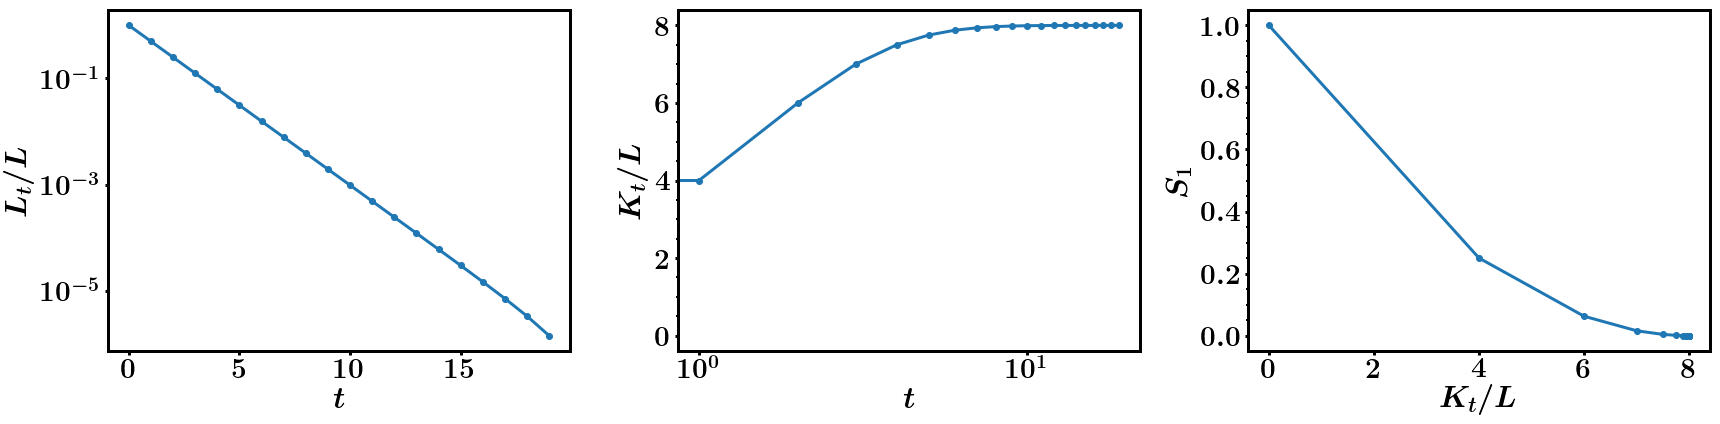

In [48]:
ncols = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6), ncols=ncols)

ax = axes[0]
ax.set_yscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$L_t/L$')
ax.plot(t_values, L_values/L, 'o-')

ax = axes[1]
ax.set_xscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$K_t/L$')
ax.plot(t_values, K_values/L, 'o-')

ax = axes[2]
#ax.set_xscale('log')
ax.set_ylabel(r'$S_1$')
ax.set_xlabel(r'$K_t/L$')
ax.plot(K_values/(L), L_values**2/(L*L), 'o-')


plt.tight_layout()
plt.show()

In [73]:
def load_delta(net_type, size, param, attack, nseeds):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    delta_file_name = os.path.join(dir_name, base_net_name,
        base_net_name_size, 'Delta_values_' + attack + '_nSeeds{:d}.txt'.format(nseeds)
    )
    delta_values = np.loadtxt(delta_file_name)
    return delta_values

def average_delta(net_type, param, attack, N_values, nseeds):
    mean_pos_values = []
    mean_delta_values = []
    std_delta_values = []
    for N in N_values:
        delta_values = load_delta(net_type, N, param, attack, nseeds)
        pos, delta = delta_values.mean(axis=0)
        std_pos, std_delta = delta_values.std(axis=0)
        mean_pos_values.append(pos)
        mean_delta_values.append(delta)
        std_delta_values.append(std_delta)
    return mean_pos_values, mean_delta_values, std_delta_values

net_type = 'DT'
param = 'param'
nseeds = 1000
attack = 'BtwU'
ncols = 1

N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
try:
    mean_pos_values, mean_delta_values, std_delta_values = average_delta(
        net_type, param, attack, N_values, 1000
    )
except:
    mean_pos_values, mean_delta_values, std_delta_values = average_delta(
        net_type, param, attack, N_values, 100
    )
normalized_mean_delta_values = np.array(mean_delta_values) / np.array(N_values)
normalized_std_delta_values = np.array(std_delta_values) / np.array(N_values)

norm_mean_delta_values_lattice = {
    'Lattice': [],
    'Ld3': []
}
fcN_values = {
    'Lattice': [],
    'Ld3': []
}
L_values = {
    'Lattice': np.array(list(range(10, 71)) + [96]),
    'Ld3': np.arange(5, 19)
}

networks = ['Lattice', 'Ld3']
for net_type in networks:
    for L in L_values[net_type]:
        norm_mean_delta = load_delta(net_type, L, param, attack, 1)[1]
        fcN = load_delta(net_type, L, param, attack, 1)[0] + 1/(L*L)
        norm_mean_delta_values_lattice[net_type].append(norm_mean_delta)
        fcN_values[net_type].append(fcN)

    fcN_values[net_type] = np.array(fcN_values[net_type])
    
#load_delta('Lattice', 12, param, attack, 10)

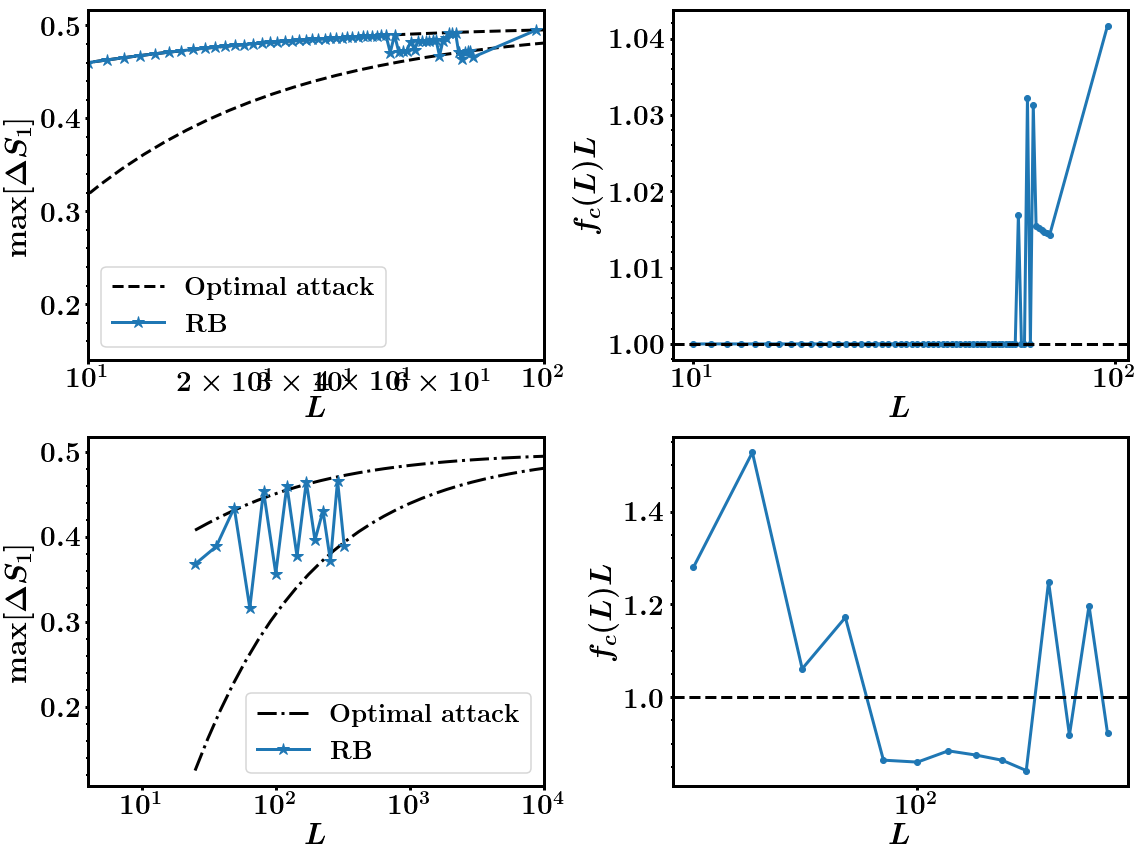

In [4]:
def delta_lattice(L, d=2):
    return 1/2 - 1/(2*L) + 1/L**d

def delta_lattice2(L, d=2):
    return 1/2 - 1/(2*L) - np.sqrt(2)/L + 1/L**d

def delta_DT(L, alpha=0):
    return ((L**2 - alpha*L)/2 + 1) / (L*L)

def fc_optim(L):
    return

def get_dim(network):
    if network == 'Lattice':
        return 2
    if network == 'Ld3':
        return 3

linestyles = ['--', '-.']
X = np.logspace(np.log10(5), 3)
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, network in enumerate(networks):
    
    dim = get_dim(network)
    
    ax = axes[i][0]
    if network == 'Lattice':
        ax.set_xlim(10, 100)
    else:
        ax.set_xlim(4, 10000)
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\mathrm{max}[\Delta S_1]$')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.plot(X**(dim-1), delta_lattice(X, d=dim), linestyles[i], color='k', label=r'$\mathrm{Optimal\;attack}$')
    ax.plot(X**(dim-1), delta_lattice2(X, d=dim), linestyles[i], color='k')
    #ax.plot(_L_values, delta_DT(_L_values, alpha=5), '--', color='k')
    #ax.plot(np.sqrt(N_values), normalized_mean_delta_values, 's-')
    ax.plot(L_values[network]**(dim-1), norm_mean_delta_values_lattice[network], '*-', 
            markersize=12, label=attack_dict[attack])
    ax.legend()

    ax = axes[i][1]
    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$f_c(L) L$')
    ax.plot(L_values[network]**(dim-1), fcN_values[network]*L_values[network], 'o-')
    ax.axhline(1, linestyle='--', label=r'$\mathrm{Optimal\;attack}$', color='k')

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'Delta_and_fcL_Lattice')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

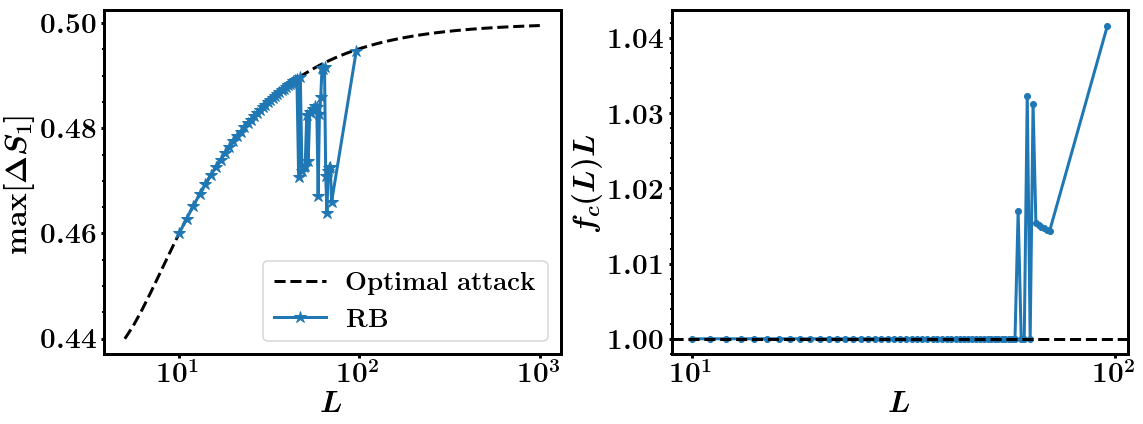

In [77]:
linestyles = ['--', '-.']
X = np.logspace(np.log10(5), 3)
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, network in enumerate(networks[0:1]):
    
    dim = get_dim(network)
    
    ax = axes[0]
    
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\Delta$')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.plot(X**(dim-1), delta_lattice(X, d=dim), linestyles[i], color='k', label=r'$\mathrm{Optimal\;attack}$')
    ax.plot(L_values[network]**(dim-1), norm_mean_delta_values_lattice[network], '*-', 
            markersize=12, label=attack_dict[attack])
    ax.legend()

    ax = axes[1]
    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$r_c(L) L$')
    ax.plot(L_values[network]**(dim-1), fcN_values[network]*L_values[network], 'o-')
    ax.axhline(1, linestyle='--', label=r'$\mathrm{Optimal\;attack}$', color='k')

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'Delta_and_fcL_Lattice')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [119]:
L = 64
N = L*L
seed = 0
g = create_proximity_graph('DT', N=N, random_seed=seed)
position = g.vs['position']
btw_values = np.array(g.betweenness(directed=False)) / N
deg_seq = g.degree()
g.summary()

'IGRAPH U--- 16384 49121 -- \n+ attr: position (v)'

In [135]:
perc_90 = sorted(btw_values)[int(0.9*N):]
perc_95 = sorted(btw_values)[int(0.95*N):]
perc_97 = sorted(btw_values)[int(0.97*N):]

In [87]:
d_values = []
for s in range(N):
    for t in range(s+1, N):
        d = distance(s, t, position)
        d_values.append(d)

KeyboardInterrupt: 

In [42]:
print(np.min(d_values))
print(np.mean(d_values), np.std(d_values))
print(np.max(d_values))


0.001658409158821031
0.5284925797873308 0.2514766460273368
1.3243120709356555


(array([1079., 2767., 4268., 5419., 6421., 6943., 7207., 7102., 7158.,
        6674., 6097., 5340., 4610., 3684., 2553., 1316.,  663.,  329.,
         135.,   35.]),
 array([0.00165841, 0.06779109, 0.13392378, 0.20005646, 0.26618914,
        0.33232182, 0.39845451, 0.46458719, 0.53071987, 0.59685256,
        0.66298524, 0.72911792, 0.79525061, 0.86138329, 0.92751597,
        0.99364866, 1.05978134, 1.12591402, 1.1920467 , 1.25817939,
        1.32431207]),
 <a list of 20 Patch objects>)

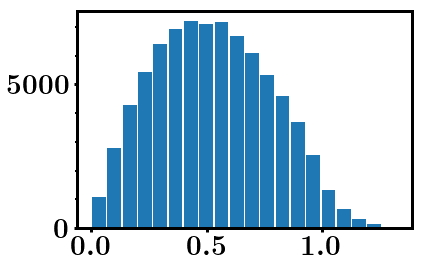

In [44]:
plt.hist(d_values, bins=20, rwidth=0.9)

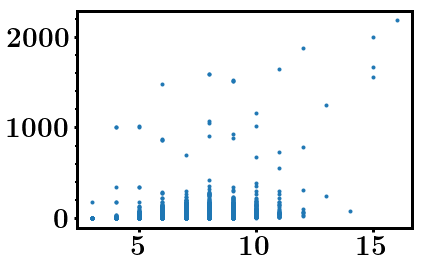

In [120]:
plt.plot(deg_seq, btw_values, '.')

(array([0.000e+00, 0.000e+00, 0.000e+00, 2.090e+02, 1.808e+03, 4.284e+03,
        4.695e+03, 3.229e+03, 1.493e+03, 4.980e+02, 1.170e+02, 3.500e+01,
        9.000e+00, 2.000e+00, 1.000e+00, 4.000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 16 Patch objects>)

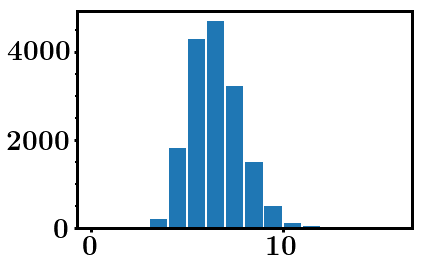

In [121]:
plt.hist(deg_seq, bins=range(max(deg_seq)+1), rwidth=0.9)

In [127]:
center = [0.5, 0.5]
d_to_center = [distance(center, position[i]) for i in range(N)]
d_to_border = [
    np.min([
        position[i][0], 1-position[i][0], position[i][1], 1-position[i][1]
    ]) for i in range(N)
]

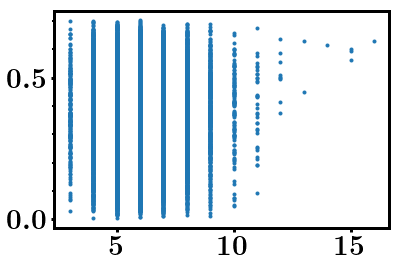

In [123]:
plt.plot(deg_seq, d_to_center, '.')

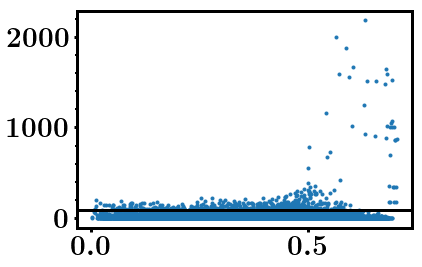

In [136]:
plt.plot(d_to_center, np.array(btw_values), '.')
plt.axhline(perc_97[0], color='k')

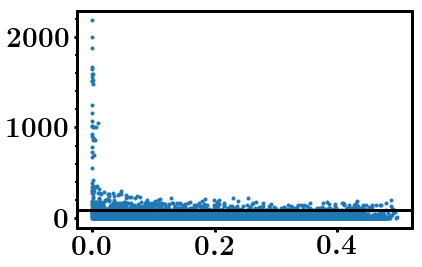

In [137]:
plt.plot(d_to_border, np.array(btw_values), '.')
plt.axhline(perc_97[0], color='k')

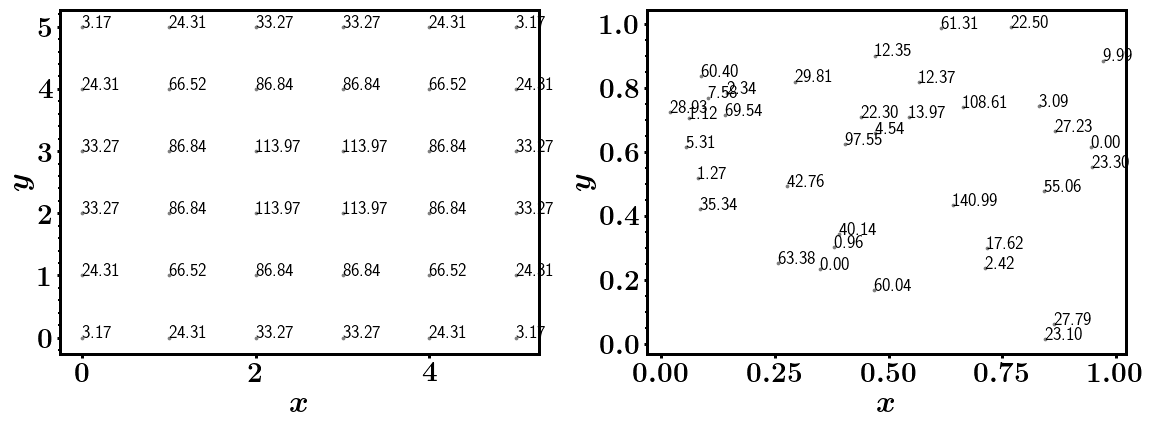

In [149]:
L = 6
N = L*L
btw_values = {}
position = {}
networks = ['Lattice', 'DT']

g = ig.Graph().Lattice(dim=[L, L], circular=False)
btw_values['Lattice'] = g.betweenness(directed=False)
position['Lattice'] = np.array([[i//L, i%L] for i in range(N)])

h = create_proximity_graph('DT', N)
btw_values['DT'] = h.betweenness(directed=False)
position['DT'] = h.vs['position']
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for k, net in enumerate(networks):

    ax = axes[k]
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

    ax.set_xticks = range(L)
    ax.set_yticks = range(L)

    for i in range(N):
        ax.text(*position[net][i], '{:.2f}'.format(btw_values[net][i]), fontsize=18)
        ax.scatter(*position[net][i], s=5, color='grey')
            
plt.tight_layout()
#fig_name = os.path.join(fig_dir, 'Btw_vs_BtwU_Lattice_L{}'.format(L))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')
plt.show()

In [6]:
mean = [0, 0]
sigma_x = 3
sigma_y = 3
cov = [
    [sigma_x, -2],
    [-2, sigma_y]
]
n = 10000
data = np.random.multivariate_normal(mean, cov, n)
x, y = data.T

In [7]:
data.T

array([[-0.20017746, -1.22477476, -2.22183762, ...,  0.07017234,
         0.22127923, -0.14239495],
       [-1.96987752,  0.90958979,  0.09472864, ..., -1.23013836,
         1.02456624,  1.30853768]])

In [8]:
cov_mat = np.cov(data.T)
print(cov_mat)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

order = eig_vals.argsort()[::-1]
eig_vals = eig_vals[order]
eig_vecs = eig_vecs[order]

lambda1, lambda2 = eig_vals

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
print('lambda1 / lambda2 =', lambda2/lambda1)

[[ 3.03539622 -2.00747862]
 [-2.00747862  2.93370869]]
Eigenvectors 
[[-0.71600246  0.69809775]
 [-0.69809775 -0.71600246]]

Eigenvalues 
[4.99267483 0.97643008]
lambda1 / lambda2 = 0.19557253574731376


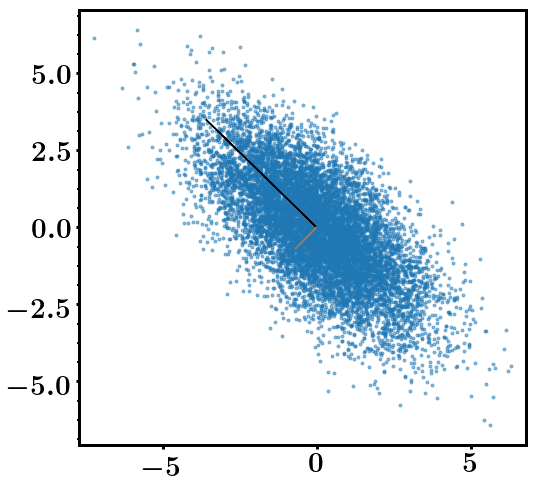

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x, y, '.', color=colors[0], zorder=0, alpha=0.5)
ax.axis('equal')
_colors = ['k', 'grey']
for i in range(2):
    ax.arrow(0, 0, eig_vals[i]*eig_vecs[i][0], eig_vals[i]*eig_vecs[i][1], color=_colors[i])

plt.show()

In [ ]:
N_values = [128, 256, 512, 1024, 2048, 4096, 8192]
max_seed = 1000
for N in N_values:
    
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size[net_type], param)
    base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)
    
    
    
    oi_file_name = os.path.join(attack_dir_name, 'oi_list.txt')
    index_list = np.loadtxt(oi_file_name, dtype='int')
    index_lists[net_type] = index_list
    

In [ ]:
def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error


def get_nodes_in_window(positions, x, y, L):
    
    nodes_in_window = []
    for i, (xi, yi) in enumerate(positions):
        
        if (x <= xi < x + L):
            if (y <= yi < y + L):
                nodes_in_window.append(i)
                
    return set(nodes_in_window)

def get_box_count(positions, indices):

    N0 = len(positions)
    L0 = int(np.sqrt(N))
    
    indices = set(indices)
    
    L_values = []
    box_count = {}
    
    L = 2
    while L <= L0:
        box_count[L] = 0
        for y in range(0, L0, L):
            for x in range(0, L0, L):
                nodes = get_nodes_in_window(positions, x, y, L)
        
                nodes_window = nodes.intersection(indices)
                if nodes_window:
                    box_count[L] += 1
        L_values.append(L)
        L = 2*L
    
    L_values = np.array(L_values)
    
    return box_count, L_values

ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols,10*nrows), ncols=ncols, nrows=nrows)
ax = axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$N_B$')
ax.text(0.6, 0.8, r'$N(\delta) \sim$', fontsize=28)
for i, network in enumerate(networks):
    position = positions[network]
    index_list = index_lists[network]
    th = thresholds[network]

    attacked_nodes = index_list[:th[1]]
    box_count, L_values = get_box_count(position, attacked_nodes)
    #L_values = L_values[:-1]
    box_count_values = np.array([box_count[L] for L in L_values])
    
    Y_pred, slope, y_err = getLinearReg(L_values, box_count_values)
    
    ax.plot(L_values, box_count_values, 'o', color=colors[i], label=network)
    label = r'$d_B = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
    ax.plot(L_values, Y_pred, '--', color=colors[i], label=label)

ax.legend()    
plt.show()